# Курсовая работа: Предварительный анализ данных и построение признаков в задачах распознавания темы текста

**Тема:** Предварительный анализ данных и построение признаков в задачах распознавания темы текста

**Цель работы:**
- Продемонстрировать владение навыками работы с методами машинного обучения с учителем и без учителя и инструментальными средствами Python.
- Провести подготовительный и описательный анализ данных, визуализировать результаты, обучить и улучшить модели, сделать выводы.

---

## Описание набора данных и постановка задачи

Данные представляют собой тексты постов из русскоязычных спортивных сообществ, размеченные по видам спорта. Задача: классификация текста по теме (вид спорта).

## Содержание

1. Установка и импорт библиотек
2. Загрузка и ознакомление с данными
3. Предварительный анализ и очистка данных  
4. Преобразование признаков и векторизация текста  
5. Описательный анализ данных
6. Методы обучения без учителя  
7. Разбиение на обучающую и тестовую выборки  
8. Обучение моделей
9. Конвейеры и отбор признаков
10. Расширенные модели (XGBoost, SVC, Stacking)

## 1. Установка и импорт библиотек


In [ ]:
# Установка необходимых библиотек и импорт
!pip install kaggle xgboost nltk seaborn

import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score, silhouette_score

from xgboost import XGBClassifier


## 2. Загрузка и ознакомление с данными

В этом разделе мы просматриваем содержимое папки `data` и загружаем тренировочный и тестовый наборы данных для дальнейшего анализа.


In [ ]:
# Настройка Kaggle API
import json, os
kaggle_json = 'kaggle.json'
with open(kaggle_json) as f:
    cred = json.load(f)
os.environ['KAGGLE_USERNAME'] = cred['username']
os.environ['KAGGLE_KEY'] = cred['key']

# Загрузка и распаковка данных
!kaggle datasets download -d mikhailma/russian-social-media-text-classification -q
!unzip -o russian-social-media-text-classification.zip -d data


Dataset URL: https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification
License(s): CC0-1.0
Archive:  russian-social-media-text-classification.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [ ]:
!ls data

sample_submission.csv  test.csv  train.csv


In [ ]:
import pandas as pd

# путь к данным, распакованным в папку `data`
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

print(f"Train shape: {train.shape}")
print(f"Test  shape: {test.shape}")

train.head()

Train shape: (38740, 3)
Test  shape: (26260, 2)


,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...


## 3. Предварительный анализ и очистка данных

Проверяем наличие дубликатов, пропущенных значений и распределение целевой переменной.


Duplicated in train: 431
Missing values per column:
 oid         0
category    0
text        0
dtype: int64


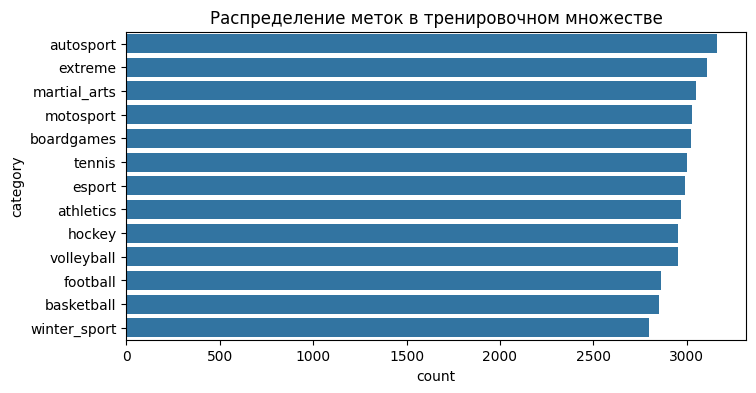


=== winter_sport ===
Волшебные фото Виктория Поплавская ЕвгенияМедведева Evgentokenoid

=== extreme ===
Возвращение в подземелье Треша 33 Эйфория тупости и жадности зашкаливает 33 В этот раз мы посетим Ростовскую область. Всю. И знаете это пока что единственный выпуск в котором не будет. . . А впрочем сами все увидите 33 Ссылка на видео в источнике

=== football ===
Лучшие чешские вратари – Доминик Доминатор Гашек и Петр Танкист Чех. Примечательно что в детстве Чех мечтал стать хоккеистом а его кумиром был никто иной как Доминик Гашек. Однако стать звездой НХЛ Чеху было не суждено. Петр родился в небогатой семье денег едва хватало на базовые расходы а хоккейная экипировка оказалась не по карману его родителям. А вот футбольные принадлежности родители могли купить без проблем поэтому Петр и выбрал данный вид спорта. Чех хоть и был очень огорчен но решил что однажды обязательно будет играть в хоккей. И его мечта сбылась. Уже после завершения футбольной карьеры он подписал контракт с анг

In [ ]:
# 3.1 Проверка на дубликаты и пропуски
print("Duplicated in train:", train.duplicated().sum())
print("Missing values per column:\n", train.isna().sum())

# 3.2 Распределение классов
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(y='category', data=train, order=train['category'].value_counts().index)
plt.title("Распределение меток в тренировочном множестве")
plt.show()

# 3.3 Примеры текстов по нескольким классам
for cat in train['category'].unique()[:5]:
    print(f"\n=== {cat} ===")
    print(train[train['category']==cat]['text'].iloc[0])


<a id="features"></a>
## 4. Преобразование признаков и векторизация текста

Конвертируем текстовые данные в числовые признаки с помощью TF-IDF, используя список русских стоп-слов.


In [ ]:
# Векторизация текста (TF-IDF) с русскими стоп-словами
import nltk
nltk.download('stopwords')  # выполните один раз в окружении

from nltk.corpus import stopwords
rus_stop = stopwords.words('russian')

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    stop_words=rus_stop  # передаём список, а не строку 'russian'
)

X_tfidf = tfidf.fit_transform(train['text'])
print("Размер TF-IDF матрицы:", X_tfidf.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Размер TF-IDF матрицы: (38740, 10000)


<a id="eda"></a>
## 5. Описательный анализ данных

Проводим анализ длины текстов, распределения частот и визуализацию ключевых характеристик.


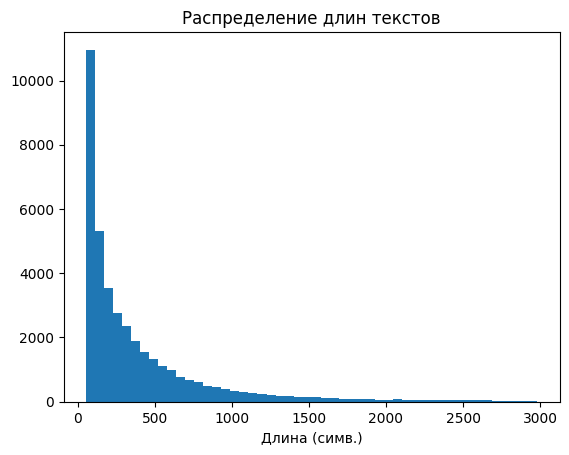

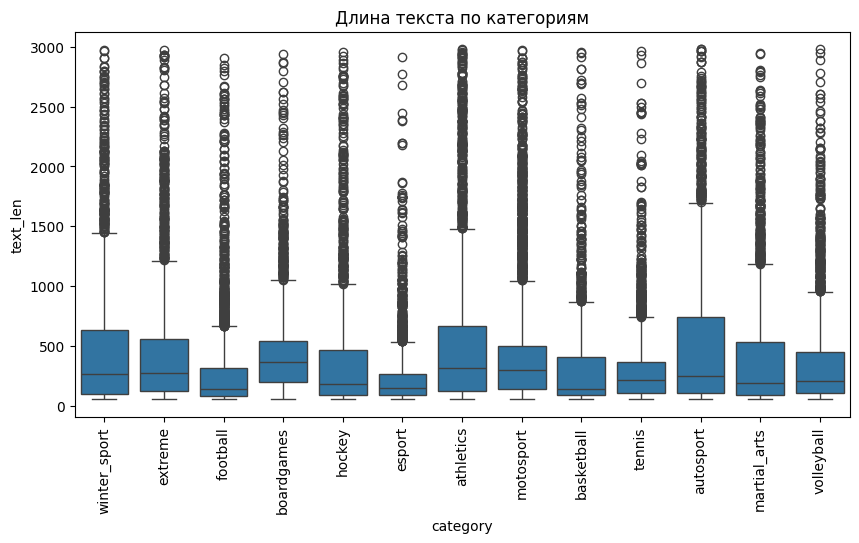

Shapiro–Wilk: статистика = 0.7012, p-value = 2.0487e-69


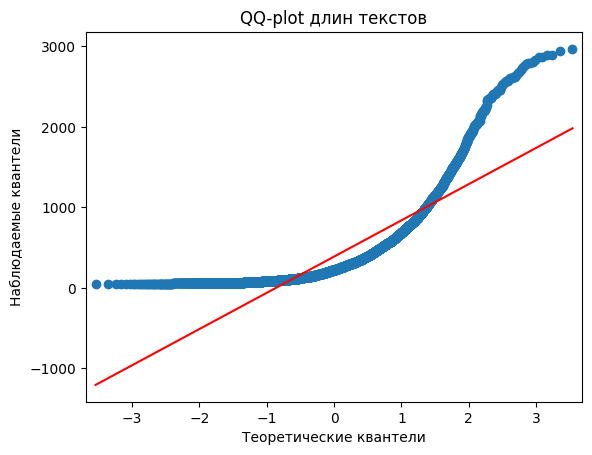

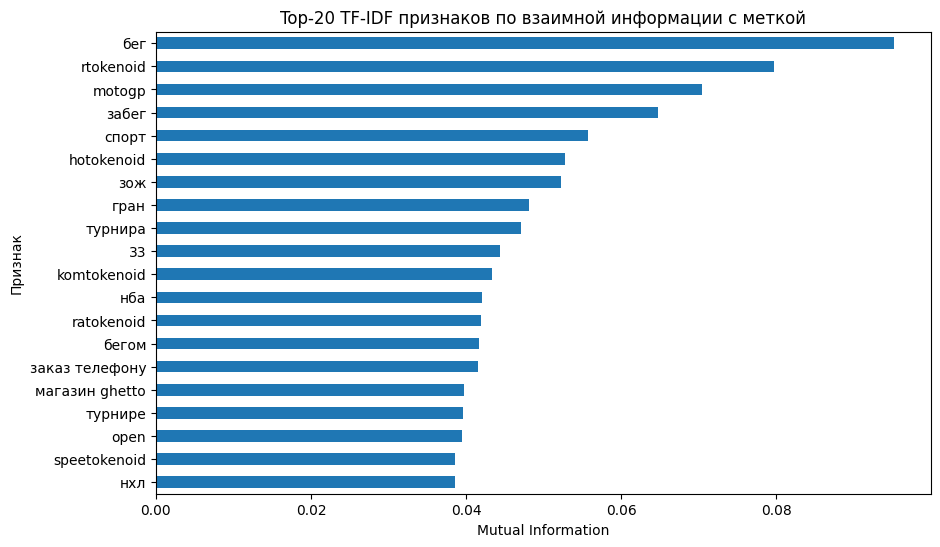

In [ ]:
# 5.1 Длина текстов
train['text_len'] = train['text'].str.len()
plt.hist(train['text_len'], bins=50)
plt.title("Распределение длин текстов")
plt.xlabel("Длина (симв.)")
plt.show()

# 5.2 Корреляция длины и метки (boxplot)
plt.figure(figsize=(10,5))
sns.boxplot(x='category', y='text_len', data=train)
plt.xticks(rotation=90)
plt.title("Длина текста по категориям")
plt.show()

# 5.3 Проверка нормальности распределения длин текстов (Shapiro–Wilk, QQ-plot)
from scipy.stats import shapiro
import statsmodels.api as sm

# Shapiro–Wilk тест (на выборке до 5000 записей)
sample_len = train['text_len'].sample(5000, random_state=42)
stat, p_value = shapiro(sample_len)
print(f"Shapiro–Wilk: статистика = {stat:.4f}, p-value = {p_value:.4e}")

# QQ-plot
sm.qqplot(sample_len, line='s')
plt.title("QQ-plot длин текстов")
plt.xlabel("Теоретические квантели")
plt.ylabel("Наблюдаемые квантели")
plt.show()

# 5.4 Коррелограмма TF-IDF-признаков с метками (mutual_info_classif через предварительный отбор chi2)
import numpy as np
from sklearn.feature_selection import chi2, mutual_info_classif

# 1) Отбираем 1000 наиболее значимых признаков по chi2
chi2_scores, _ = chi2(X_tfidf, train['category'])
idx_topchi2 = np.argsort(chi2_scores)[-1000:]

# 2) Для mutual_info_classif берём случайную подвыборку документов (чтобы не раздувать память)
rng = np.random.RandomState(42)
sample_idx = rng.choice(train.shape[0], size=5000, replace=False)
X_sub = X_tfidf[sample_idx][:, idx_topchi2].toarray()
y_sub = train['category'].iloc[sample_idx]

# 3) Вычисляем взаимную информацию
mi = mutual_info_classif(X_sub, y_sub, discrete_features=False, random_state=42)

# 4) Формируем серию и берём топ-20
feature_names = np.array(tfidf.get_feature_names_out())[idx_topchi2]
mi_series = pd.Series(mi, index=feature_names)
mi_top20 = mi_series.sort_values(ascending=False).head(20)

# 5) Визуализация
plt.figure(figsize=(10,6))
mi_top20.sort_values().plot.barh()
plt.title("Top-20 TF-IDF признаков по взаимной информации с меткой")
plt.xlabel("Mutual Information")
plt.ylabel("Признак")
plt.show()



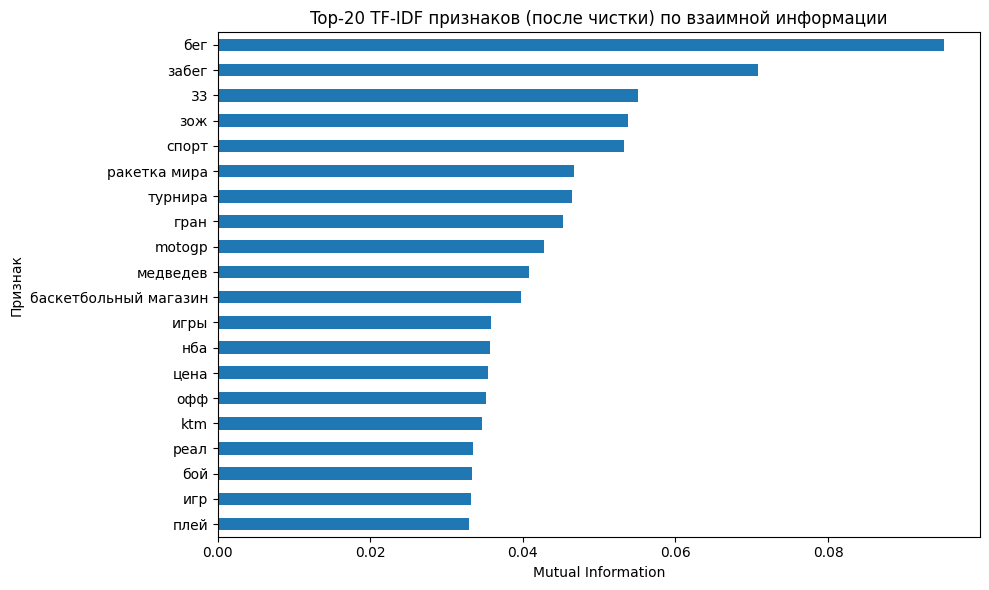

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, mutual_info_classif

# 1) Клонируем оригинальные тексты и делаем столбец clean_text
df = train.copy()
def clean_tokenoids(s):
    return re.sub(r'\b\w*tokenoid\w*\b', '', s, flags=re.IGNORECASE).strip()

df['clean_text'] = df['text'].apply(clean_tokenoids)

# 2) Векторизация с фильтрацией по частотам
tfidf_clean = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    stop_words=rus_stop,
    min_df=5,
    max_df=0.9
)
X_clean = tfidf_clean.fit_transform(df['clean_text'])

# 3) Отбор 1000 лучших по chi2, чтобы ускорить MI
chi2_scores, _ = chi2(X_clean, df['category'])
top_chi2_idx = np.argsort(chi2_scores)[-1000:]

# 4) Случайная подвыборка для MI
rng = np.random.RandomState(42)
sample_idx = rng.choice(df.shape[0], size=5000, replace=False)
X_sub = X_clean[sample_idx][:, top_chi2_idx].toarray()
y_sub = df['category'].iloc[sample_idx]

# 5) Mutual information
mi = mutual_info_classif(X_sub, y_sub, discrete_features=False, random_state=42)

# 6) Топ-20 и визуализация
feature_names = np.array(tfidf_clean.get_feature_names_out())[top_chi2_idx]
mi_series = pd.Series(mi, index=feature_names).sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
mi_series.sort_values().plot.barh()
plt.title("Top-20 TF-IDF признаков (после чистки) по взаимной информации")
plt.xlabel("Mutual Information")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()

Duplicated in train: 431
Missing values per column:
 oid         0
category    0
text        0
dtype: int64


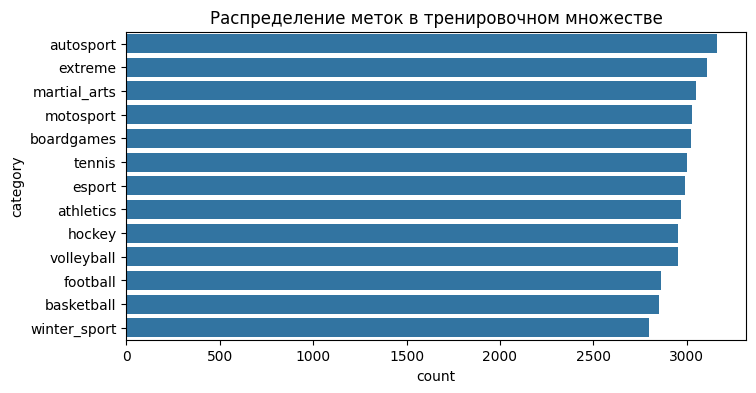


=== Примеры ДО чистки «tokenoid» ===

--- winter_sport ---
Волшебные фото Виктория Поплавская ЕвгенияМедведева Evgentokenoid

--- extreme ---
Возвращение в подземелье Треша 33 Эйфория тупости и жадности зашкаливает 33 В этот раз мы посетим Ростовскую область. Всю. И знаете это пока что единственный выпуск в котором не будет. . . А впрочем сами все увидите 33 Ссылка на видео в источнике

--- football ---
Лучшие чешские вратари – Доминик Доминатор Гашек и Петр Танкист Чех. Примечательно что в детстве Чех мечтал стать хоккеистом а его кумиром был никто иной как Доминик Гашек. Однако стать звездой НХЛ Чеху было не суждено. Петр родился в небогатой семье денег едва хватало на базовые расходы а хоккейная экипировка оказалась не по карману его родителям. А вот футбольные принадлежности родители могли купить без проблем поэтому Петр и выбрал данный вид спорта. Чех хоть и был очень огорчен но решил что однажды обязательно будет играть в хоккей. И его мечта сбылась. Уже после завершения футболь

In [ ]:
import re
import seaborn as sns
import matplotlib.pyplot as plt

# 2.1 Проверка на дубликаты и пропуски
print("Duplicated in train:", train.duplicated().sum())
print("Missing values per column:\n", train.isna().sum())

# 2.2 Распределение классов
plt.figure(figsize=(8,4))
sns.countplot(y='category', data=train, order=train['category'].value_counts().index)
plt.title("Распределение меток в тренировочном множестве")
plt.show()

# 2.3 Примеры текстов ДО чистки
print("\n=== Примеры ДО чистки «tokenoid» ===")
for cat in train['category'].unique()[:3]:
    text = train[train['category']==cat]['text'].iloc[0]
    print(f"\n--- {cat} ---\n{text}")

# 2.4 Чистка «tokenoid» и похожих шумовых токенов
def remove_tokenoids(s):
    # удаляем все слова, содержащие «tokenoid»
    return re.sub(r'\b\w*tokenoid\w*\b', '', s, flags=re.IGNORECASE)

train['text'] = train['text'].apply(remove_tokenoids) \
                         .str.replace(r'\s+', ' ', regex=True) \
                         .str.strip()

# 2.5 Примеры текстов ПОСЛЕ чистки
print("\n=== Примеры ПОСЛЕ чистки «tokenoid» ===")
for cat in train['category'].unique()[:3]:
    text = train[train['category']==cat]['text'].iloc[0]
    print(f"\n--- {cat} ---\n{text}")


## 6. Методы обучения без учителя

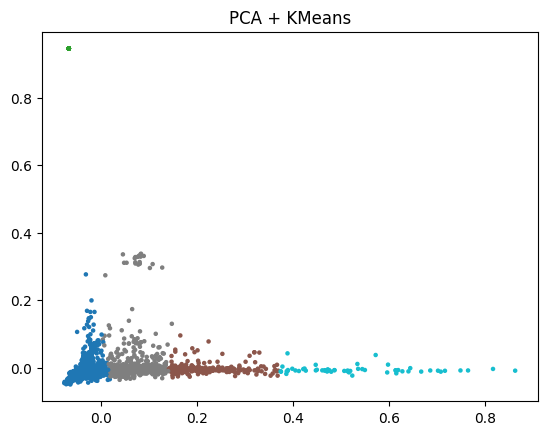

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 6.1 PCA для снижения размерности до 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray()[:5000])  # для ускорения

# 6.2 Кластеризация KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
labels_km = kmeans.fit_predict(X_pca)

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_km, s=5, cmap='tab10')
plt.title("PCA + KMeans")
plt.show()

## 7. Разбиение на обучающую и тестовую выборки

In [ ]:
from sklearn.model_selection import train_test_split

X = X_tfidf
y = train['category']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print(X_train.shape, X_val.shape)

(30992, 10000) (7748, 10000)


<a id="models"></a>
## 8. Обучение моделей

Обучаем несколько базовых моделей для классификации текстов и оцениваем их качество.


In [ ]:
# Обучение на подвыборке для ускорения тренировки

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# 1) Кодируем метки
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)

# 2) Формируем подвыборку из X_train для ускорения
SAMPLE_FRAC = 0.3  # 30% от обучающей выборки
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train_enc,
    train_size=SAMPLE_FRAC,
    stratify=y_train_enc,
    random_state=42
)
print(f"Размер полной обучающей выборки: {X_train.shape[0]}")
print(f"Размер подвыборки для тренировки: {X_train_sub.shape[0]}")

# 3) Задаём модели
models = {
    "LogReg"   : LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
    "MultNB"   : MultinomialNB(),
    "LinearSVC": LinearSVC(random_state=42),
    "RF"       : RandomForestClassifier(n_jobs=-1, random_state=42),
    "GB"       : GradientBoostingClassifier(random_state=42),
    "XGB"      : XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "KNN"      : KNeighborsClassifier(),
}

# 4) Обучаем и оцениваем на подвыборке
results_sub = {}
for name, model in models.items():
    print(f"\n=== Обучение модели: {name} на подвыборке ===")
    get_ipython().run_line_magic('time', f'model.fit(X_train_sub, y_train_sub)')
    score = model.score(X_val, y_val_enc)
    print(f"{name}: точность на валидации = {score:.4f}")
    results_sub[name] = score

# 5) Сводка
print("\nСравнение моделей (точность) при обучении на подвыборке:")
for name, score in results_sub.items():
    print(f"  {name:<8} : {score:.4f}")


Размер полной обучающей выборки: 30992
Размер подвыборки для тренировки: 9297

=== Обучение модели: LogReg на подвыборке ===
CPU times: user 47.6 ms, sys: 15.3 ms, total: 62.9 ms
Wall time: 3.31 s
LogReg: точность на валидации = 0.7624

=== Обучение модели: MultNB на подвыборке ===
CPU times: user 7.57 ms, sys: 0 ns, total: 7.57 ms
Wall time: 7.68 ms
MultNB: точность на валидации = 0.7456

=== Обучение модели: LinearSVC на подвыборке ===
CPU times: user 349 ms, sys: 5 µs, total: 349 ms
Wall time: 348 ms
LinearSVC: точность на валидации = 0.7768

=== Обучение модели: RF на подвыборке ===
CPU times: user 27.4 s, sys: 139 ms, total: 27.5 s
Wall time: 15.6 s
RF: точность на валидации = 0.7012

=== Обучение модели: GB на подвыборке ===
CPU times: user 2min 39s, sys: 172 ms, total: 2min 39s
Wall time: 2min 41s
GB: точность на валидации = 0.7026

=== Обучение модели: XGB на подвыборке ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:41:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: user 3min 31s, sys: 887 ms, total: 3min 31s
Wall time: 2min 2s
XGB: точность на валидации = 0.7152

=== Обучение модели: KNN на подвыборке ===
CPU times: user 5.66 ms, sys: 0 ns, total: 5.66 ms
Wall time: 5.4 ms
KNN: точность на валидации = 0.2091

Сравнение моделей (точность) при обучении на подвыборке:
  LogReg   : 0.7624
  MultNB   : 0.7456
  LinearSVC : 0.7768
  RF       : 0.7012
  GB       : 0.7026
  XGB      : 0.7152
  KNN      : 0.2091


<a id="pipelines"></a>
## 9. Конвейеры и отбор признаков

Строим пайплайны с отбором признаков и интеграцией SVD, проводим оценку на валидационной выборке.


In [ ]:
import time
import pandas as pd
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score

# ————————————————
# 1) Загрузка и подготовка данных
train = pd.read_csv('data/train.csv')
X = train['text']
y = train['category']

# 2) Разбиение и кодирование меток
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)

# 3) Список русских стоп-слов
rus_stop = stopwords.words('russian')

# ————————————————
# 4) Pipeline #1: TF-IDF → SelectKBest(chi2) → LogisticRegression
pipe_fs = Pipeline([
    ('tfidf',  TfidfVectorizer(max_features=10000,
                               ngram_range=(1,2),
                               stop_words=rus_stop)),
    ('select', SelectKBest(score_func=chi2)),             # отбор k лучших
    ('clf',    LogisticRegression(max_iter=1000,
                                  n_jobs=-1,
                                  random_state=42))
])

# 5) Grid Search для pipeline #1 (подбираем k признаков и C)
param_grid_fs = {
    'select__k': [3000, 5000, 8000],
    'clf__C':    [0.1, 1, 10]
}
grid_fs = GridSearchCV(pipe_fs,
                       param_grid=param_grid_fs,
                       cv=3,
                       n_jobs=-1,
                       verbose=1,
                       scoring='accuracy')

start = time.time()
grid_fs.fit(X_train, y_train_enc)
print(f"\nGridSearch занял {time.time()-start:.1f} сек")
print("Лучшие параметры:", grid_fs.best_params_)
print(f"CV точность: {grid_fs.best_score_:.4f}")

# Оцениваем лучший pipeline #1 на валидации
best_fs = grid_fs.best_estimator_
y_pred1 = best_fs.predict(X_val)
print(f"\nAccuracy pipeline #1: {accuracy_score(y_val_enc, y_pred1):.4f}")
print("Отчёт pipeline #1:\n", classification_report(y_val_enc, y_pred1, target_names=le.classes_))

# ————————————————
# 6) Pipeline #2: TF-IDF → TruncatedSVD → LinearSVC
pipe_svd = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000,
                              ngram_range=(1,2),
                              stop_words=rus_stop)),
    ('svd',   TruncatedSVD(n_components=300, random_state=42)),
    ('clf',   LinearSVC(random_state=42))
])

start = time.time()
pipe_svd.fit(X_train, y_train_enc)
print(f"\nTraining pipeline #2 заняло {time.time()-start:.1f} сек")
y_pred2 = pipe_svd.predict(X_val)
print(f"Accuracy pipeline #2: {accuracy_score(y_val_enc, y_pred2):.4f}")
print("Отчёт pipeline #2:\n", classification_report(y_val_enc, y_pred2, target_names=le.classes_))

# ————————————————
# 7) Усиление: VotingClassifier из лучших pipeline #1 и pipeline #2
voting = VotingClassifier(
    estimators=[('fs', best_fs), ('svd', pipe_svd)],
    voting='hard',
    n_jobs=-1
)
start = time.time()
voting.fit(X_train, y_train_enc)
print(f"\nTraining VotingClassifier заняло {time.time()-start:.1f} сек")
y_pred_v = voting.predict(X_val)
print(f"Accuracy ансамбля: {accuracy_score(y_val_enc, y_pred_v):.4f}")
print("Отчёт ансамбля:\n", classification_report(y_val_enc, y_pred_v, target_names=le.classes_))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 3 folds for each of 9 candidates, totalling 27 fits

GridSearch занял 225.4 сек
Лучшие параметры: {'clf__C': 10, 'select__k': 8000}
CV точность: 0.7974

Accuracy pipeline #1: 0.8121
Отчёт pipeline #1:
               precision    recall  f1-score   support

   athletics       0.89      0.87      0.88       594
   autosport       0.84      0.81      0.82       632
  basketball       0.86      0.81      0.84       570
  boardgames       0.91      0.92      0.91       604
      esport       0.70      0.75      0.72       598
     extreme       0.64      0.74      0.69       622
    football       0.73      0.72      0.72       572
      hockey       0.82      0.80      0.81       590
martial_arts       0.70      0.71      0.70       610
   motosport       0.88      0.86      0.87       606
      tennis       0.96      0.92      0.94       600
  volleyball       0.88      0.82      0.85       590
winter_sport       0.81      0.83      0.82       560

    accuracy                    

<a id="advanced"></a>
## 10. Расширенные модели (XGBoost, SVC, Stacking)

In [ ]:
# Метод 3: Stacking Ensemble — стекинг лучших моделей
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('fs',  best_fs),    # лучший pipeline с SelectKBest + LogReg
    ('svd', pipe_svd),   # pipeline с SVD + LinearSVC
    ('xgb', pipe_xgb)    # pipeline с XGBoost
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=3,
    n_jobs=-1
)

start = time.time()
stack.fit(X_train, y_train_enc)
print(f"StackingClassifier обучен за {time.time() - start:.1f} сек")

y_pred_stack = stack.predict(X_val)
print(f"Accuracy StackingClassifier: {accuracy_score(y_val_enc, y_pred_stack):.4f}")
print("Отчёт StackingClassifier:\n", classification_report(y_val_enc, y_pred_stack, target_names=le.classes_))

StackingClassifier обучен за 2894.9 сек
Accuracy StackingClassifier: 0.8264
Отчёт StackingClassifier:
               precision    recall  f1-score   support

   athletics       0.91      0.87      0.89       594
   autosport       0.85      0.83      0.84       632
  basketball       0.90      0.86      0.88       570
  boardgames       0.92      0.92      0.92       604
      esport       0.71      0.76      0.74       598
     extreme       0.63      0.75      0.68       622
    football       0.75      0.73      0.74       572
      hockey       0.84      0.83      0.84       590
martial_arts       0.72      0.72      0.72       610
   motosport       0.90      0.85      0.88       606
      tennis       0.96      0.94      0.95       600
  volleyball       0.89      0.84      0.87       590
winter_sport       0.82      0.85      0.84       560

    accuracy                           0.83      7748
   macro avg       0.83      0.83      0.83      7748
weighted avg       0.83      0.